Short overview of the windowpeps code. It's recommended to first check out the infinite peps code.

In [1]:
using MPSKit,PEPSKit,TensorKit,OptimKit,Plots,Test

┌ Info: Precompiling PEPSKit [52969e89-939e-4361-9b68-9bc7cde4bdeb]
└ @ Base loading.jl:1260


Window peps is a mutable window of peps tensors, embedded in an infinite peps. First we instantiate an infinite peps ...

In [37]:
data = map(Iterators.product(1:2,1:2)) do (i,j)
    TensorMap(rand,ComplexF64,ℂ^2*ℂ^2*(ℂ^2)'*(ℂ^2)',(ℂ^2)')
end

peps = InfPEPS(data);

After which we can easily construct a window. The window's size needs to be a multiple of the infinite peps unit cell, because this simplified the code greatly.

In [38]:
@test_throws ArgumentError WinPEPS(peps,9,8) #this fails

window = WinPEPS(peps,8,8); #this works

The window peps environments can only be created starting from the infinite peps environments.

In [39]:
function bound_finalize(iter,state,ham,pars)
    maxD = 10;
    
    # check every virtual bond dimension and see if it's larger then maxD
    bigenough = reduce((a,(i,j))-> a && dim(virtualspace(state,i,j))>=maxD,
        Iterators.product(1:size(state,1),1:size(state,2)),init=true)
    
    if !bigenough 
        (state,pars) = changebonds(state,ham,OptimalExpand(trscheme=truncdim(3)),pars)
    end
    
    return (state,pars,true)
end

inf_env = params(peps,alg=Vumps(verbose=false,finalize=bound_finalize));

window_env = params(window,inf_env,Dmrg2(trscheme=truncdim(20),verbose=false));

total inconsistency 0.00045415864498518134


Using this we can calculate properties of the window state

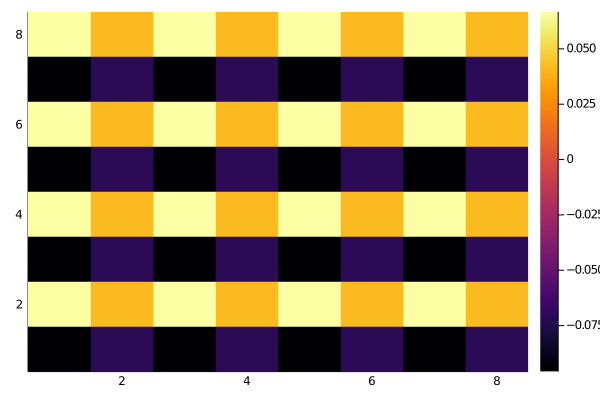

In [40]:
sz = TensorMap([1 0;0 -1],ℂ^2,ℂ^2)
heatmap(real.(expectation_value(window_env,sz)))

In [41]:
ham = nonsym_nn_xxz_ham();
expectation_value(window_env,ham)

27.693168393826326 - 3.0272202542075173e-16im

Channels don't work yet